In [1]:
import numpy as np
import sys
import time
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_digits
from ipywidgets import interact
from sklearn.decomposition import PCA

In [105]:
def sigmoid(X):
    return 1. / (1. + np.exp(-X))

def sigmoid_grad(X):
    return sigmoid(X) * ( 1 - sigmoid(X) )

def relu(X):
    return (X + np.abs(X)) / 2.

def relu_grad(X):
#     return relu(X) - relu(X-1)
    return sigmoid(X)

class NeuralNetworkWithPCA(object):
    def __init__(self, layers=(2,2,1), learning_rate=0.1, num_epochs=10, activation='relu', use_pca=(True,True,)):
        self.num_layers = len(layers)
        self.layers = layers
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.use_pca = use_pca
        
        self.nodes = list(range(self.num_layers))
        self.grad = list(range(self.num_layers))
        self.dw = list(range(self.num_layers-1))
        self.weights = list(range(self.num_layers-1))
        self.weights_history = list(range(self.num_layers-1))
        # self.nodes[0] = np.zeros(self.num_layers[0])
        for i in range(self.num_layers - 1):
            # self.nodes[i+1] = np.zeros(self.num_layers[i+1])
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1])
            self.weights_history[i] = np.zeros((self.num_epochs+1, self.layers[i], self.layers[i+1]))
            self.weights_history[i][0] = self.weights[i]

        self.activation, self.activation_grad = self._activation_function(activation)
        self.training_accuracy = np.zeros((self.num_epochs))
        self.mse = np.zeros((self.num_epochs))
    
    def _initialise_pca(self, X):
        Xt = X.copy()
        for i in range(self.num_layers - 1):
            Xt = self._transform(Xt, layer=i)
            if self.use_pca[i]:                
                pca = PCA(n_components=self.layers[i+1])
                pca.fit(Xt)
                for j in range(self.layers[i+1]):
                    self.weights[i].T[j] = pca.components_[j]
    
    def _activation_function(self, name):
        funcs = {
            'relu': (relu, relu_grad),
            'sigmoid': (sigmoid, sigmoid_grad),
        }
        return funcs[name]

    def _transform(self, X, layer=1):
        if layer == 0:
            return X
        return self.activation(np.dot(X, self.weights[layer-1]))
    
    def _cum_transform(self, X, layer=1):
        if layer > self.num_layers:
            raise Exception("There are only %d layers, but you specified the %dth layer" % (self.num_layers, layer))
        out = X
        for i in range(1, layer):
            out = self._transform(out, layer=i)
        return out
    
    def _compute_gradient(self, x, y):
        pass
    
    def _forward(self, X):
        self.nodes[0] = X
        for i in range(1, self.num_layers):
            self.nodes[i] = self._transform(self.nodes[i-1], layer=i)
        self.output = self.nodes[self.num_layers-1]
        return self.output

    def fit(self, X, y):
        n = X.shape[0]
        
        if self.use_pca:
            self._initialise_pca(X)
        
        start = time.time()
        num_progress_bars = 20
        
        for i in range(self.num_epochs):
            self._forward(X)
            # print([n.shape for n in self.nodes])
            error = y - self.output
            self.grad_output = error * self.activation_grad(self.output)
            self.grad[self.num_layers-1] = error * self.activation_grad(self.output)
            for j in range(self.num_layers-2, -1, -1):
                # print(self.grad[j+1].shape, self.weights[j].T.shape, self.nodes[j+1].shape)
                self.grad[j] = np.dot(self.grad[j+1], self.weights[j].T) * self.activation_grad(self.nodes[j])
                self.dw[j] = np.dot(self.nodes[j].T, self.grad[j+1])
                self.weights[j] += self.learning_rate * self.dw[j] / n
                self.weights_history[j][i] = self.weights[j]

            finish = time.time()
            elapsed_time = float(time.time() - start)

            correct = len([e for e in error if abs(e) < 0.5])
            training_accuracy = float(correct) / n
            self.training_accuracy[i] = training_accuracy
            
            mse = np.sum(error**2) / n
            self.mse[i] = mse
            
            progress = round(float(i)/self.num_epochs * num_progress_bars)

            print("\r" + " "*80, end='\r')
            print("\r" + ("Training Accuracy: %0.3g%% Time elapsed: %0.2gs |" + "="*(progress) + " "*(num_progress_bars-progress) + "|") % (training_accuracy * 100, elapsed_time), end='\r')
    
    def predict(self, X):
        return self.predict_proba(X)
    
    def predict_proba(self, X):
        return self._forward(X)
    
    def score(self, X, y):
        n = X.shape[0]
        self._forward(X)
        error = y - self.output
        correct = len([e for e in error if abs(e) < 0.5])
        training_accuracy = float(correct) / n
        return training_accuracy
    
    def _mse(self, X, y, epoch=None):
        n = X.shape[0]
        output = self._forward_history(X, epoch=epoch)
        mse = (y - output)**2
        return np.sum(error) / n
    
    def _layer_0_transform(self, X, epoch=None):
        epoch = self.num_epochs - 1 if epoch is None else epoch
        return self.activation(np.dot(X, self.weights_0_1_history[epoch]))
    
    def _forward_history(self, X, epoch=None):
        epoch = self.num_epochs - 1 if epoch is None else epoch
        hidden = self.activation(np.dot(X, self.weights_0_1_history[epoch]))
        output = self.activation(np.dot(hidden, self.weights_1_2_history[epoch]))
        return output

In [45]:
n = 1000
d = 4
X = np.random.randn(n, d)
m = np.median(np.linalg.norm(X, axis=1))
y = np.array([1 if np.linalg.norm(x) >= m else 0 for x in X])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, shuffle=True, random_state=42)

/Users/AnnaLeonard/miniconda3/envs/py3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [136]:
np.random.seed(41)
num_epochs=10000
num_hidden=3
num_layers = 10
nets = []
for num_pca in range(num_layers):
    layers = (d,) + (num_hidden,)*(num_layers-2) + (1,)
    use_pca = (True,)*num_pca + (False,)*(num_layers-1-num_pca)
    nn = NeuralNetworkWithPCA(layers=layers, num_epochs=num_epochs, learning_rate=0.1, use_pca=use_pca)
    nets.append(nn)

In [137]:
for i in range(len(nets)):
    n = nets[i]
    print("Training net %d of %d" % (i, len(nets)))
    n.fit(X_train, y_train[:, None])

Training net 0 of 10


/Users/AnnaLeonard/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in add
  


Training net 1 of 10% Time elapsed: 25s |====================|                  
Training net 2 of 10% Time elapsed: 30s |====================|                  
Training net 3 of 10% Time elapsed: 24s |====================|                  
Training net 4 of 10% Time elapsed: 28s |====================|                  
Training net 5 of 10% Time elapsed: 24s |====================|                  
Training net 6 of 10% Time elapsed: 24s |====================|                  
Training net 7 of 10% Time elapsed: 25s |====================|                  
Training net 8 of 103.5% Time elapsed: 25s |====================|               
Training net 9 of 101.5% Time elapsed: 25s |====================|               


In [138]:
print("Test accuracies\n" + "\n".join(["%d: %0.3g%%" % (i, 100*nets[i].score(X_test, y_test[:, None])) for i in range(len(nets))]))

Test accuracies
0: 0%
1: 0%
2: 0%
3: 0%
4: 0%
5: 0%
6: 0%
7: 76.4%
8: 76.4%
9: 74.4%


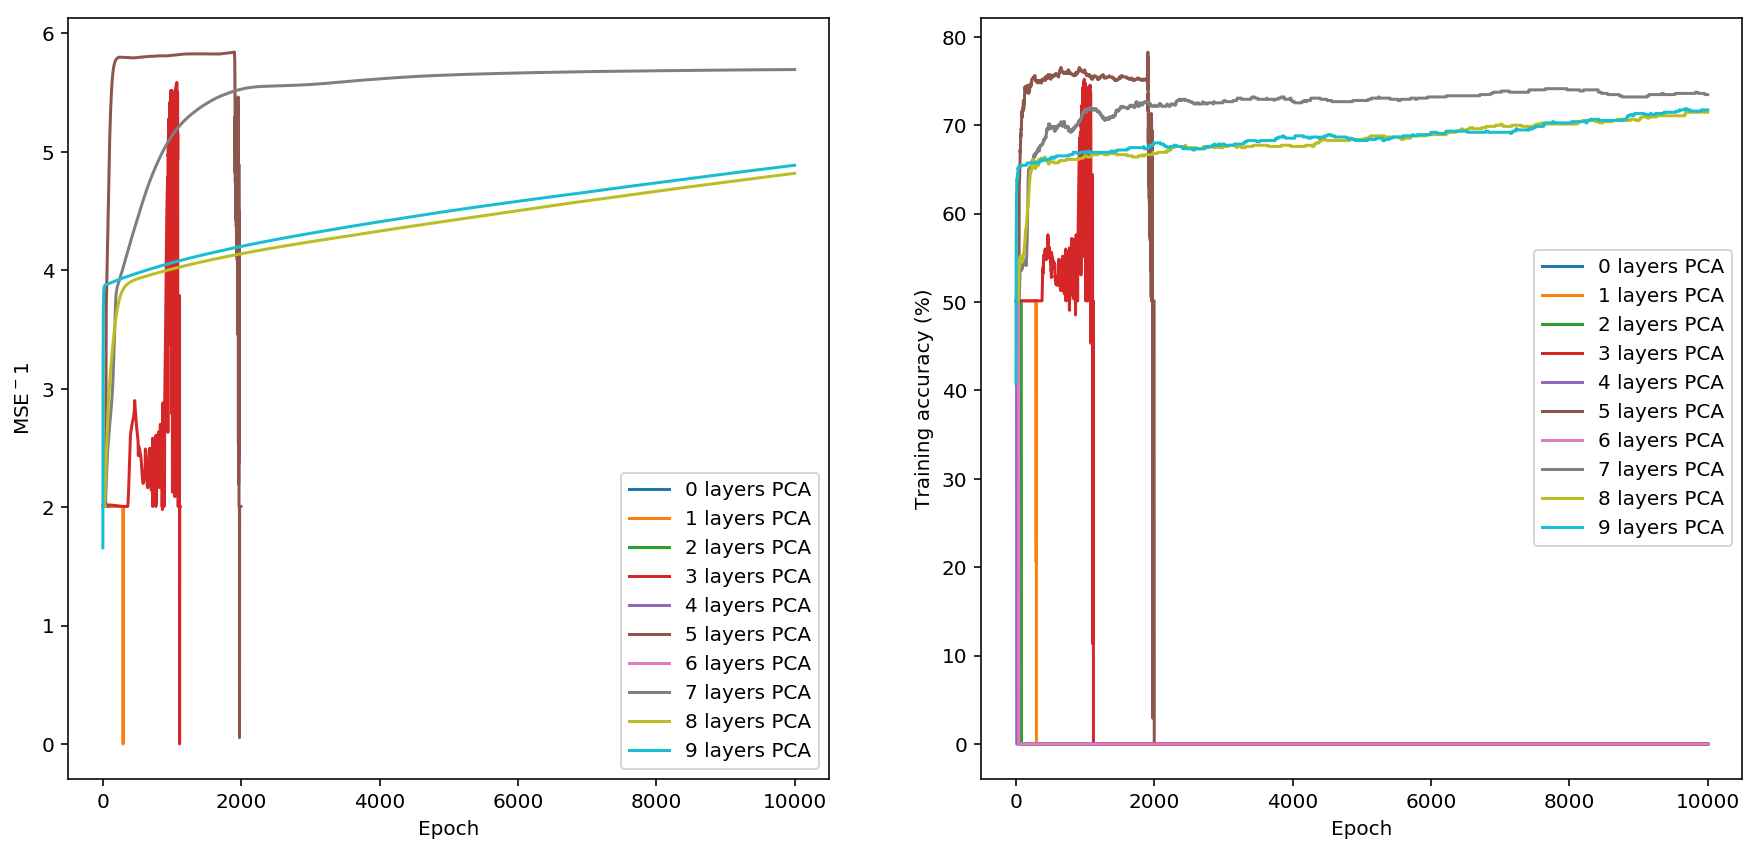

In [139]:
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for i in range(len(nets)):
    nn = nets[i]
    ax.plot(nn.mse**-1, label="%d layers PCA" % i)
    ax2.plot(nn.training_accuracy*100, label="%d layers PCA" % i)
ax.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")
ax.set_ylabel("MSE$^-1$")
ax2.set_ylabel("Training accuracy (%)")
ax.legend()
ax2.legend()

In [132]:
nets[5].mse[-1]**-1

5.8735862222604007

In [134]:
nets[8].use_pca

[True, True, True, True, True, True, True, True, False]